In [1]:
%run ../tools/imports.ipynb
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

h = pickle.load(open("../handler.p", "rb"))
def preprocess(X, y, standardization=None):
    
    if standardization is None:
        standardization = [StandardScaler() for i in range(3)]
        fitted = False
    else:
        fitted = True
    
    weather = h.get_weather_from_list(epw_files=X.iloc[:,-1] , n_cols=len(h.columns))

    if fitted:
        weather = standardization[0].transform(weather)
        params = standardization[1].transform(X.iloc[:,:-1])
        y = standardization[2].transform(np.log1p(y))
    else:
        weather = standardization[0].fit_transform(weather)
        params = standardization[1].fit_transform(X.iloc[:,:-1])
        standardization[2].mean_ = np.log1p(y.values).mean().mean()
        standardization[2].scale_ = np.log1p(y.values).ravel().std()
        y = standardization[2].transform(np.log1p(y))
    weather_list=[]
    weather = weather.transpose()
    for i in range(len(X)):
        weather_list.append(weather[:,i*8760:(i+1)*8760].ravel())
    weather = np.array(weather_list)
    
    X = np.hstack((weather, params))
    
    return X, y, standardization

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Couldn't import dot_parser, loading of dot files will not be possible.


/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [2]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'

    def __init__(self, X_raw, y_raw, list_IDs, standardizer, batch_size=32, shuffle=True):
        'Initialization'
        self.X_raw = X_raw
        self.y_raw = y_raw
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.standardizer = standardizer
        self.on_epoch_end()

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X, y,_ = np.array(preprocess(self.X_raw.iloc[list_IDs_temp,:14], self.y_raw.iloc[list_IDs_temp,:], self.standardizer))
        
        y = np.expand_dims(y,2)
        return X, y

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))



    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

In [3]:
standardizer = pickle.load(open('standardizer_hourly.p','rb'))

In [6]:
from tensorflow.keras.layers import Reshape, Permute, Lambda
from tensorflow.keras.models import model_from_json

# load json and create model
json_file = open("model_hourly_new_architecture_trainall_new.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
ann_h = model_from_json(loaded_model_json)
# load weights into new model
ann_h.load_weights("model_hourly_new_architecture_trainall_new.h5")
print("Loaded model from disk")

Loaded model from disk


Winnipeg        R2 score:    94.16 %, MAPE:   0.00 %, RMSPE:  0.00 %.
Ottawa          R2 score:    93.16 %, MAPE:   0.00 %, RMSPE:  0.00 %.
Longueuil       R2 score:    92.45 %, MAPE:   0.00 %, RMSPE:  0.00 %.
Toronto         R2 score:    90.73 %, MAPE:   0.00 %, RMSPE:  0.00 %.
Taloyoak        R2 score:    88.16 %, MAPE:   0.00 %, RMSPE:  0.00 %.
Lesage          R2 score:    92.06 %, MAPE:   0.00 %, RMSPE:  0.00 %.
Montreal        R2 score:    93.05 %, MAPE:   0.00 %, RMSPE:  0.00 %.
Norman_Wells    R2 score:    91.27 %, MAPE:   0.00 %, RMSPE:  0.00 %.
Edmonton        R2 score:    92.53 %, MAPE:   0.00 %, RMSPE:  0.00 %.
Victoria        R2 score:    73.55 %, MAPE:   0.00 %, RMSPE:  0.00 %.
Hamilton        R2 score:    90.48 %, MAPE:   0.00 %, RMSPE:  0.00 %.
Halifax         R2 score:    88.09 %, MAPE:   0.00 %, RMSPE:  0.00 %.
London          R2 score:    91.34 %, MAPE:   0.00 %, RMSPE:  0.00 %.
Laval           R2 score:    92.55 %, MAPE:   0.00 %, RMSPE:  0.00 %.
Calgary         R2 s

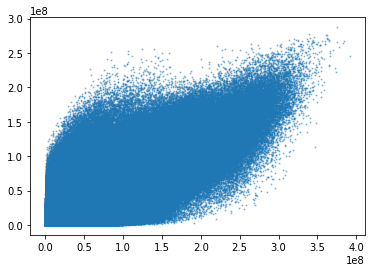

In [15]:
%%time
y_test_list = []
y_pred_list = []
scores = np.ndarray((20,3))
for i, city in enumerate(CAN_cities.keys()):
    X_test = pd.read_csv('../Data_unseen/X_test_'+city+'.csv.gz', index_col='Unnamed: 0').iloc[:,:14]
    y_test = pd.DataFrame(np.load('../Data_unseen/hourly_data/y_hourly_h_23_part_'+city+'.npy'))
    test_generator = DataGenerator(X_test, y_test, np.arange(len(X_test), dtype=int), 
                                   standardizer, batch_size=1, shuffle=False)
    
    y_pred = ann_h.predict_generator(test_generator).squeeze()
    #y_true = np.exp(standardizer[2].inverse_transform(y_test.values.reshape(len(X_test))))
    y_pred = np.expm1(standardizer[2].inverse_transform(y_pred))
    y_test =np.transpose(y_test.values)
    y_pred = np.transpose(y_pred)
    scores[i, 0] = r2_score(y_test, y_pred) * 100
    scores[i, 1] = 0#MAPE(y_test.ravel(), y_pred.ravel())
    scores[i, 2] = 0#RMSPE(y_test.ravel(), y_pred.ravel())
    if city=='Victoria':
        plt.scatter(y_test, y_pred, s=1, alpha=0.4)
    y_test_list.append(y_test.ravel())
    y_pred_list.append(y_pred.ravel())
    print(f'{city:15s} R2 score: {scores[i, 0]:8.2f} %, MAPE: {scores[i, 1]:6.2f} %, RMSPE: {scores[i, 2]:5.2f} %.')

print()
print(f'{"Mean":15s} R2 score: {np.mean(scores[:,0]):8.2f} %,MAPE: {np.mean(scores[:,1]):6.2f} %, RMSPE: {np.mean(scores[:,2]):5.2f} %.')

In [16]:
%%time
y_test = [item for sublist in y_test_list for item in sublist]
del y_test_list, X_test

CPU times: user 9.75 s, sys: 1.3 s, total: 11.1 s
Wall time: 11.1 s


In [17]:
y_pred = [item for sublist in y_pred_list for item in sublist]
del y_pred_list

In [18]:
del y_pred[-50000000:0]

In [19]:
del y_test[-50000000:0]

In [14]:
print(r2_score(y_test[:50000000], y_pred[:50000000]) * 100)

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

# Make plot for hourly prediction

In [13]:
for i, city in enumerate(CAN_cities.keys()):
    if i<1:
        X_test = pd.read_csv('../Data_unseen/X_test_'+city+'.csv.gz', index_col='Unnamed: 0').iloc[:,:14]
        y_test = pd.DataFrame(np.load('../Data_unseen/hourly_data/y_hourly_h_23_part_'+city+'.npy'))
        test_generator = DataGenerator(X_test, y_test, np.arange(len(X_test), dtype=int), 
                                       standardizer, batch_size=1, shuffle=False)

        y_pred = ann_h.predict_generator(test_generator).squeeze()
        #y_true = np.exp(standardizer[2].inverse_transform(y_test.values.reshape(len(X_test))))
        y_pred = np.expm1(standardizer[2].inverse_transform(y_pred))

In [14]:
y_test.shape

(505, 8760)

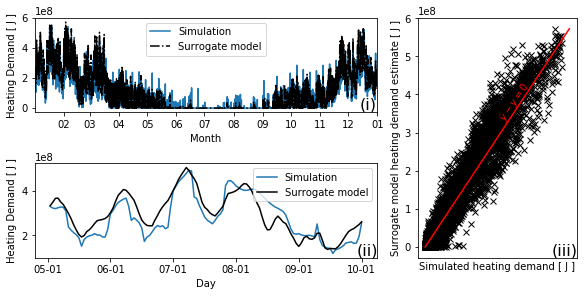

In [87]:
import matplotlib.dates as mdates
fig3 = plt.figure(constrained_layout=True, figsize=(8,4))
gs = fig3.add_gridspec(2, 11)
ax = fig3.add_subplot(gs[0, :-5])
#y_test = y_test.transpose()
#y_test.index = pd.date_range(start='1/1/2019 01:00:00',end='1/1/2020 00:00:00',freq='H')
ax.plot(y_test.index, y_test.iloc[:,0],)
ax.plot(y_test.index , y_pred[0,:],'k-.')
ax.set_xlim([y_test.index[0],y_test.index[-1]])
# set monthly locator
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# set formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m'))
plt.ylabel('Heating Demand [ J ]')
plt.xlabel('Month')
plt.legend(['Simulation','Surrogate model'])
ax.text(0.95, 0.03,'(i)', transform=ax.transAxes, fontsize=16)
#plt.savefig('Annual_hourlysurrogate.pdf')


start = 96
ax = fig3.add_subplot(gs[1, :-5])
ax.plot(y_test.index[start:216], y_test.iloc[start:216, 0])
ax.plot(y_test.index[start:216] , y_pred[0,start:216],'k')
# set monthly locator
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
# set formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.legend(['Simulation','Surrogate model'])
plt.ylabel('Heating Demand [ J ]')
plt.xlabel('Day')
ax.text(0.94, 0.03,'(ii)', transform=ax.transAxes, fontsize=16)
#plt.savefig('Daily_hourlysurrogate.pdf')

ax = fig3.add_subplot(gs[:, 6:])
ax.plot(y_test.iloc[:,0], y_pred[0,:],'kx')
ax.plot([y_test.iloc[:,0].min(), y_pred[0,:].max()], [y_test.iloc[:,0].min(), y_pred[0,:].max()] ,'r-')
ax.text(0.5, 0.57,r'$\widehat{y}-y=0$', transform=ax.transAxes, color='red',fontweight='bold', rotation=56)
# set monthly locator
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
# set formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
#plt.legend(['Simulation','Surrogate model'])
plt.xlabel('Simulated heating demand [ J ]')
plt.ylabel('Surrogate model heating demand estimate [ J ]')
ax.text(0.84, 0.01,'(iii)', transform=ax.transAxes, fontsize=16)
plt.savefig('Daily_hourlysurrogate_subplots.pdf')



In [23]:
X_test, y_test = read_samples(region=city, param_set=23, output_meter = 'DistrictHeating:Facility')

In [37]:
city='Victoria'
X_test = pd.read_csv('../Data_unseen/X_test_'+city+'.csv.gz', index_col='Unnamed: 0').iloc[:,:14]
y_test = pd.DataFrame(np.load('../Data_unseen/hourly_data/y_hourly_h_23_part_'+city+'.npy'))

In [49]:
for i in CAN_cities.values():
    print(i)

CAN_MB_Winnipeg.Richardson.Intl.AP.718520_CWEC.epw
CAN_ON_Ottawa.Intl.AP.716280_CWEC.epw
CAN_QC_Montreal-St.Hubert-Longueuil.AP.713710_CWEC.epw
CAN_ON_Toronto.Pearson.Intl.AP.716240_CWEC.epw
CAN_NU_Taloyoak.AP.715800_CWEC2016.epw
CAN_QC_Quebec-Lesage.Intl.AP.717140_CWEC.epw
CAN_QC_Montreal-Mirabel.Intl.AP.716278_CWEC.epw
CAN_NT_Norman.Wells.AP.710430_CWEC2016.epw
CAN_AB_Edmonton.Intl.AP.711230_CWEC.epw
CAN_BC_Victoria-Univ.of.Victoria.717830_CWEC2016.epw
CAN_ON_Hamilton.Intl.AP.712630_CWEC2016.epw
CAN_NS_Halifax.Dockyard.713280_CWEC2016.epw
CAN_ON_London.Intl.AP.716220_CWEC.epw
CAN_QC_Ste.Foy.Univ.Laval.713920_CWEC2016.epw
CAN_AB_Calgary.Intl.AP.718770_CWEC.epw
CAN_SK_Saskatoon.Intl.AP.718660_CWEC.epw
CAN_MB_Churchill.AP.716180_CWEC.epw
CAN_QC_Kuujuaq.AP.719060_CWEC.epw
CAN_BC_Vancouver.Intl.AP.718920_CWEC.epw
CAN_NT_Fort.Simpson.AP.719460_CWEC2016.epw


In [70]:
weather='CAN_ON_Toronto.Pearson.Intl.AP.716240_CWEC.epw'
#weather= 'CAN_BC_Victoria-Univ.of.Victoria.717830_CWEC2016.epw'
a = h.get_weather('/home/user/weather_data/data/'+weather)

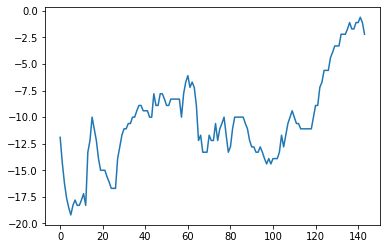

In [71]:
plt.plot(a[0:144,0])

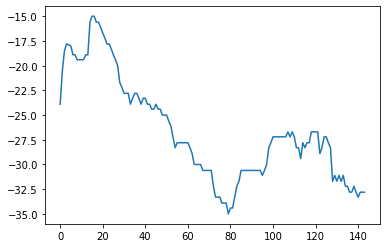

In [69]:
plt.plot(a[0:144,0])